# RFM Analysis of efood customers for January 2022

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
customer_data = pd.read_csv('Assessment.csv')

# Calculate the frequency of orders for each customer
order_frequency = customer_data.groupby('user_id')['order_id'].count().reset_index()
order_frequency.columns = ['user_id', 'frequency']


# Calculate the average order value for each customer
average_order_value = customer_data.groupby('user_id')['amount'].mean().reset_index()
average_order_value.columns = ['user_id', 'avg_order_value']

# Convert order_timestamp to datetime format
customer_data['order_timestamp'] = pd.to_datetime(customer_data['order_timestamp'])
latest_date = customer_data['order_timestamp'].max()

# Calculate the recency for each customer
customer_data['Last_Purchase_Date'] = customer_data.groupby('user_id')['order_timestamp'].transform('max')
customer_data['Recency'] = (latest_date - customer_data['Last_Purchase_Date']).dt.days

# Merge the frequency, average order value, and recency dataframes
customer_segments = pd.merge(order_frequency, average_order_value, on='user_id')
customer_segments = pd.merge(customer_segments, customer_data[['user_id', 'Recency']], on='user_id')

# Define the segments based on frequency, average order value, and recency
breakpoint_frequency = customer_segments['frequency'].quantile(0.70)
breakpoint_order_value = customer_segments['avg_order_value'].quantile(0.30)
breakpoint_recency = customer_segments['Recency'].quantile(0.50)




In [41]:
# Merge the frequency, average order value, and recency dataframes
RFM_table = pd.merge(order_frequency, average_order_value, on='user_id')
RFM_table = pd.merge(RFM_table, customer_data[['user_id', 'Recency']], on='user_id')

RFM_table.head()

,user_id,frequency,avg_order_value,Recency
0,44118921,1,33.300000,26
1,108938802,3,14.733333,4
2,108938802,3,14.733333,4
3,108938802,3,14.733333,4
4,110361993,11,12.454545,7


# Plot the distributions of 'frequency', 'avg_order_value', 'Recency'

In [44]:
# Calculate the average values
avg_recency = RFM_table['Recency'].mean()
avg_frequency = RFM_table['frequency'].mean()
avg_avg_order_value = RFM_table['avg_order_value'].mean()

# Print the average values
print("Average Recency:", avg_recency)
print("Average Frequency:", avg_frequency)
print("Average Average Order Value:", avg_avg_order_value)


Average Recency: 4.971486327137964
Average Frequency: 11.143683905141595
Average Average Order Value: 8.522366406498666


C:\Users\ilias\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ilias\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


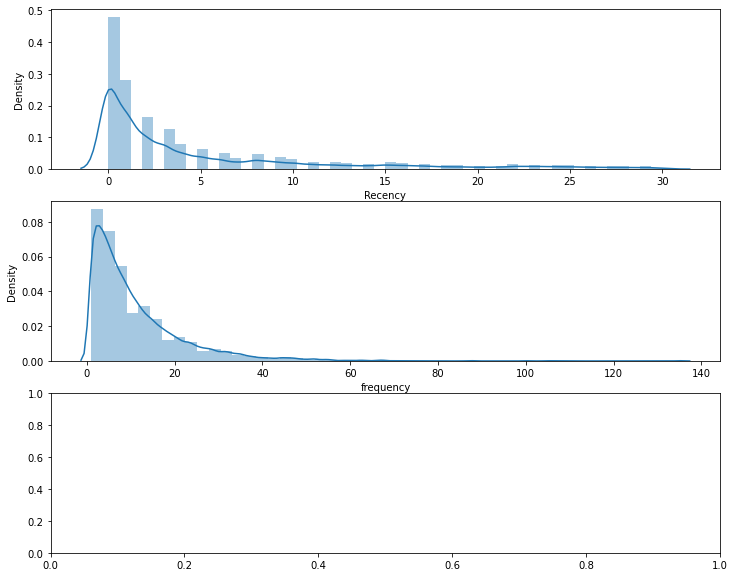

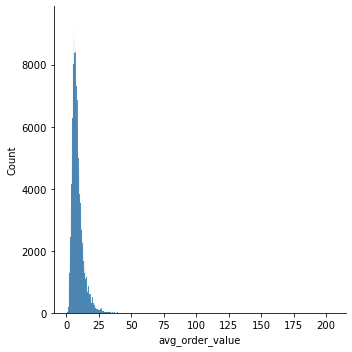

In [45]:
# Plotting RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3,1,1); sns.distplot(RFM_table['Recency'])
# Plot distribution of F
plt.subplot(3,1,2); sns.distplot(RFM_table['frequency'])
# Plot distribution of M (avg_order_value)
plt.subplot(3,1,3); sns.displot(RFM_table['avg_order_value'])
plt.show()

In [46]:
# Aggregate the metrics at the user_id level
RFM_table = customer_segments.groupby('user_id').agg({
    'frequency': 'sum',
    'avg_order_value': 'mean',
    'Recency': 'max'
}).reset_index()

In [47]:
# Calculate the quantiles for RFM segmentaion
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,user_id,frequency,avg_order_value,Recency
0.25,1.477133e+11,1.0,6.0,2.0
0.50,2.788117e+11,4.0,8.5,7.0
0.75,5.427711e+11,25.0,12.3,16.0


In [48]:
quantiles = quantiles.to_dict()

In [49]:
# RFM segmentation
RFM_Segment = RFM_table.copy()

In [50]:
# Function for assigning R class based on quartiles
def R_Class(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [51]:
# Function for assigning F/M class based on quartiles
def FM_Class(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [52]:
# Assign R, F, and M quartiles
RFM_Segment['R_Quartile'] = RFM_Segment['Recency'].apply(R_Class, args=('Recency', quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency', quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['avg_order_value'].apply(FM_Class, args=('avg_order_value', quantiles,))

In [53]:
# Create RFMClass column
RFM_Segment['RFMClass'] = RFM_Segment['R_Quartile'].map(str) + RFM_Segment['F_Quartile'].map(str) + RFM_Segment['M_Quartile'].map(str)

In [54]:
# Save table to use for Squarify plot.
# RFM_Segment.to_csv('RFM_Segment.csv')

In [55]:
RFM_Segment = pd.merge(RFM_Segment, customer_data[['user_id', 'cuisine']], on='user_id')

In [56]:
# Print the RFM table
RFM_Segment.head()

,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
0,44118921,1,33.300000,26,1,1,4,114,Meat
1,108938802,9,14.733333,4,3,3,4,334,Meat
2,108938802,9,14.733333,4,3,3,4,334,Meat
3,108938802,9,14.733333,4,3,3,4,334,Meat
4,110361993,121,12.454545,7,3,4,4,344,Breakfast


In [57]:
# Save the table to use for Squarify plot for breakfast cuisine
RFM_Segment.to_csv('RFM_Breakfast.csv')

# Which are our best customers ?

In [58]:
# RFMClass = 444 , best customers by Rank
RFM_Segment[RFM_Segment['RFMClass']=='444'].head(20)

,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
30,145424244,144,13.56250,1,4,4,4,444,Breakfast
31,145424244,144,13.56250,1,4,4,4,444,Italian
32,145424244,144,13.56250,1,4,4,4,444,Italian
33,145424244,144,13.56250,1,4,4,4,444,Italian
34,145424244,144,13.56250,1,4,4,4,444,Italian
35,145424244,144,13.56250,1,4,4,4,444,Meat
36,145424244,144,13.56250,1,4,4,4,444,Italian
37,145424244,144,13.56250,1,4,4,4,444,Meat
38,145424244,144,13.56250,1,4,4,4,444,Meat
39,145424244,144,13.56250,1,4,4,4,444,Street food


# Which customers are at the verge of churning ?

In [59]:
# Customers who's recency value is high 
RFM_Segment[RFM_Segment['R_Quartile'] <= 2 ].sort_values('avg_order_value', ascending=False).head(5)


,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
527961,677549666136,4,150.0,26,1,2,4,124,Italian
527962,677549666136,4,150.0,26,1,2,4,124,Italian
530396,679812927969,1,150.0,20,1,1,4,114,Breakfast
519136,666983637390,1,150.0,19,1,1,4,114,Italian
5009,10246587057,1,113.5,30,1,1,4,114,Meat


# Refined Customers at the verge of churning.

In [60]:
# customers that haven't ordered recently but are within the price range of breakfast.
RFM_Segment[(RFM_Segment['R_Quartile'] <= 2) & (RFM_Segment['F_Quartile'] >= 1) & (RFM_Segment['M_Quartile'] <= 3) ].sort_values('avg_order_value', ascending=False).head(5)

,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
306094,296485876932,4,12.3,22,1,2,3,123,Street food
118750,118551292776,1,12.3,21,1,1,3,113,Meat
72079,73594241658,4,12.3,21,1,2,3,123,Breakfast
72080,73594241658,4,12.3,21,1,2,3,123,Street food
274766,262826115972,1,12.3,13,2,1,3,213,Italian


# "Lost" Customers

In [61]:
# RFMClass = 111
RFM_Segment[RFM_Segment['RFMClass']=='111'].sort_values('Recency',ascending=False).head(5)

,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
50162,52363983987,1,5.9,30,1,1,1,111,Breakfast
59885,61267984407,1,3.0,30,1,1,1,111,Breakfast
434538,561777994764,1,4.5,30,1,1,1,111,Breakfast
58415,60131113560,1,4.2,30,1,1,1,111,Breakfast
58416,60141205278,1,3.5,30,1,1,1,111,Breakfast


# Loyal Customers

In [62]:
#Customers with high frequency, recency

RFM_Segment[(RFM_Segment['F_Quartile'] >= 3) & (RFM_Segment['R_Quartile'] >= 2)].head(5)


,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
1,108938802,9,14.733333,4,3,3,4,334,Meat
2,108938802,9,14.733333,4,3,3,4,334,Meat
3,108938802,9,14.733333,4,3,3,4,334,Meat
4,110361993,121,12.454545,7,3,4,4,344,Breakfast
5,110361993,121,12.454545,7,3,4,4,344,Italian


# Loyal Customers in terms of Breakfast

In [63]:
RFM_Segment[(RFM_Segment['F_Quartile'] >= 3) & (RFM_Segment['R_Quartile'] >= 2) & (RFM_Segment['cuisine']=='Breakfast')].head(5)

,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
4,110361993,121,12.454545,7,3,4,4,344,Breakfast
16,144777339,196,4.342857,0,4,4,1,441,Breakfast
17,144777339,196,4.342857,0,4,4,1,441,Breakfast
18,144777339,196,4.342857,0,4,4,1,441,Breakfast
19,144777339,196,4.342857,0,4,4,1,441,Breakfast


In [64]:
# Filter the RFM_Segment table for loyal customers with high frequency and recency, considering the 'Breakfast' cuisine
target_segment = RFM_Segment[(RFM_Segment['F_Quartile'] >= 3) & (RFM_Segment['R_Quartile'] >= 2) & (RFM_Segment['cuisine'] == 'Breakfast')]

# Print the target segment for the marketing campaign
print("Target Segment for 'Breakfast' cuisine marketing campaign:")
target_segment


Target Segment for 'Breakfast' cuisine marketing campaign:


,user_id,frequency,avg_order_value,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,cuisine
4,110361993,121,12.454545,7,3,4,4,344,Breakfast
16,144777339,196,4.342857,0,4,4,1,441,Breakfast
17,144777339,196,4.342857,0,4,4,1,441,Breakfast
18,144777339,196,4.342857,0,4,4,1,441,Breakfast
19,144777339,196,4.342857,0,4,4,1,441,Breakfast
...,...,...,...,...,...,...,...,...,...
534082,685020642600,9,2.300000,0,4,3,1,431,Breakfast
534112,685084427433,9,8.433333,0,4,3,2,432,Breakfast
534123,685116384540,16,8.850000,0,4,3,3,433,Breakfast
534124,685116384540,16,8.850000,0,4,3,3,433,Breakfast


In [65]:
RFM_Segment.shape

(534270, 9)

# Mapping dictionary for RFM Classes.

In [66]:
# Create a mapping dictionary for RFM classes
rfm_labels = {
    '444': 'Best Customers',
    '111': 'Lost Customers',
    '113': 'HR, LF, LM',
    '114': 'HR, LF, HM',
    '123': 'HR, HF, LM',
    '124': 'HR, HF, HM',
    '133': 'HR, HF, LM',
    '134': 'HR, HF, HM',
    '143': 'HR, HF, LM',
    '144': 'HR, HF, HM',
    '213': 'LR, LF, LM',
    '214': 'LR, LF, HM',
    '223': 'LR, LF, LM',
    '224': 'LR, LF, HM',
    '233': 'LR, LF, LM',
    '234': 'LR, LF, HM',
    '243': 'LR, LF, LM',
    '244': 'LR, LF, HM',
    '313': 'LR, HF, LM',
    '314': 'LR, HF, HM',
    '323': 'LR, HF, LM',
    '324': 'LR, HF, HM',
    '333': 'LR, HF, LM',
    '334': 'LR, HF, HM',
    '343': 'LR, HF, LM',
    '344': 'LR, HF, HM',
    '413': 'LR, LF, LM',
    '414': 'LR, LF, HM',
    '423': 'LR, HF, LM',
    '424': 'LR, HF, HM',
    '433': 'LR, LF, LM',
    '434': 'LR, LF, HM',
    '443': 'LR, HF, LM',
    
}

# Map RFM classes to labels
RFM_Segment['RFMLabel'] = RFM_Segment['RFMClass'].map(rfm_labels)


# Plots

## Bar Plot of RFM segments

In [67]:
# Use for custom plots 
#rfm_order=['Best Customers','Lost Customers', 'HR, LF, LM', 'HR, LF, HM', 'HR, HF, LM', 'HR, HF, HM', 'LR, LF, LM', 'LR, LF, HM', 'LR, HF, LM', 
           #'LR, HF, HM', 'LR, LF, LM', 'LR, LF, HM', 'LR, HF, LM', 'LR, HF, HM']

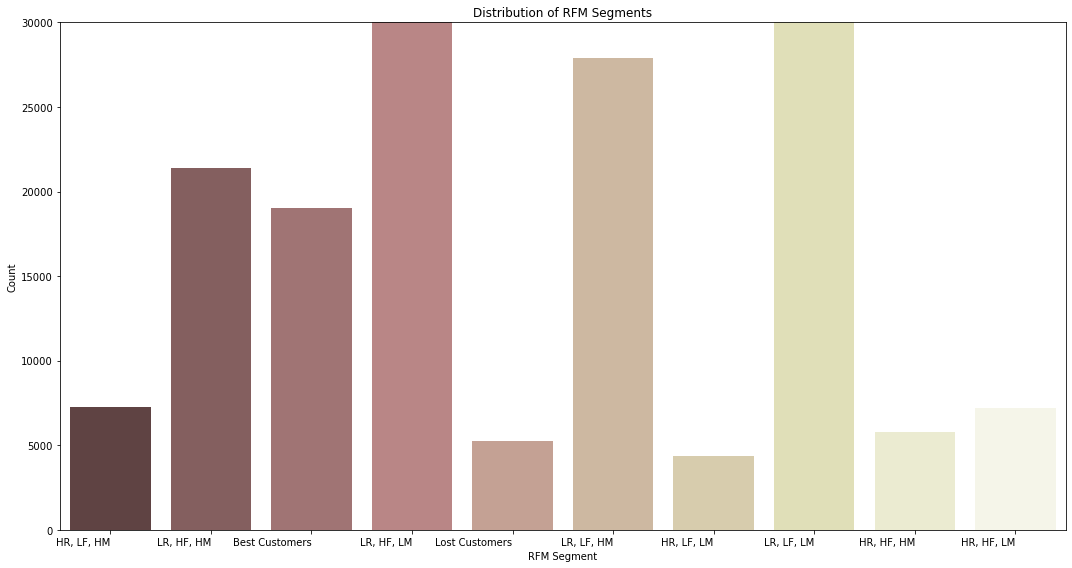

In [68]:
# Plot the counts of each RFM segment
plt.figure(figsize=(15, 8))
sns.countplot(x='RFMLabel', data=RFM_Segment, palette='pink')
plt.xlabel('RFM Segment')
plt.ylabel('Count')
plt.title('Distribution of RFM Segments')
plt.xticks(rotation=0, ha = 'right')
plt.ylim(0,30000)
plt.tight_layout()
plt.show()


## Scatter plot of Recency vs. Frequency

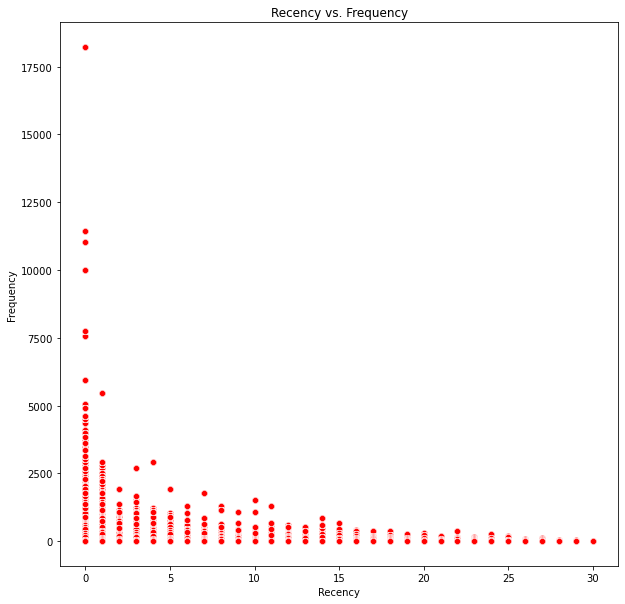

In [69]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='Recency', y='frequency', data=RFM_Segment, color='red')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs. Frequency')
plt.show()


## Box plot of Monetary value:

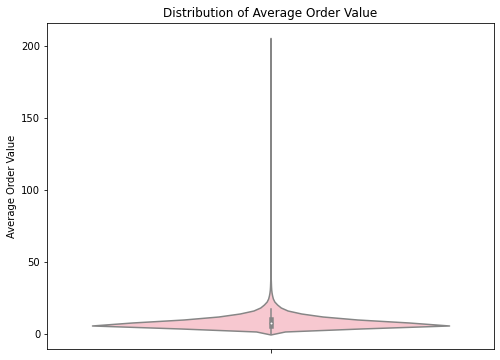

In [70]:
plt.figure(figsize=(8, 6))
sns.violinplot(y='avg_order_value', data=RFM_Segment, color='pink')
plt.ylabel('Average Order Value')
plt.title('Distribution of Average Order Value')
plt.show()


## Bar plot of cuisine distribution within RFM segments:

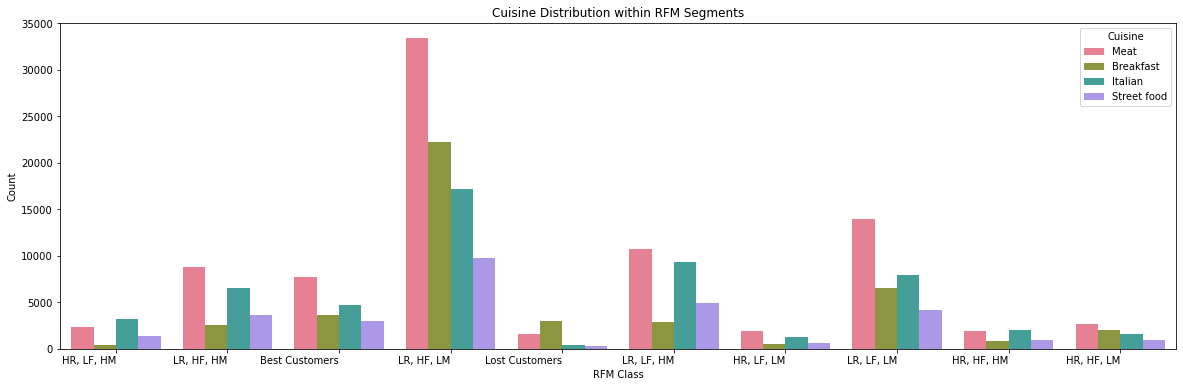

In [71]:
plt.figure(figsize=(20, 6))
sns.countplot(x='RFMLabel', hue='cuisine', data=RFM_Segment, palette='husl')
plt.xlabel('RFM Class')
plt.ylabel('Count')
plt.title('Cuisine Distribution within RFM Segments')
plt.xticks(rotation=0, ha = 'right')
plt.legend(title='Cuisine')
plt.show()
